In [1]:
from misc_util import util#util.play, util.specplot
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

TRAIN_TFRECORD = 'data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'
SAVE_DIR = 'models/ddsp-vocal-decoder'
TEST_WPATH = "16ktest_segment.wav"

c:\Users\TheoA\Anaconda3\envs\tflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[ 0.0324504   0.03388482  0.03385471 ... -0.03361278 -0.03469073
  -0.03574734]]


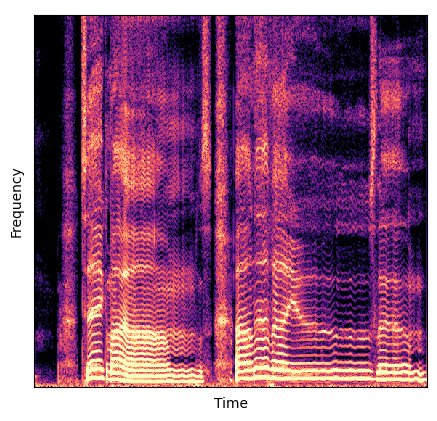

In [3]:
from misc_util.util import specplot, play
import librosa    
audio, s = librosa.load(TEST_WPATH, sr=16000) # Downsample 44.1kHz to 16kHz
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
print(audio)
specplot(audio)
play(audio)

In [4]:
import time
import os
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = np.array(audio_features['loudness_db']).astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size


gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]

print("===Trained model===")
print("Time Steps", time_steps_train)
print("Samples", n_samples_train)
print("Hop Size", hop_size)
print("\n===Resynthesis===")
print("Time Steps", time_steps)
print("Samples", n_samples)
print('')


c:\Users\TheoA\Anaconda3\envs\tflow\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


Audio features took 7.9 seconds
===Trained model===
Time Steps 1000
Samples 64000
Hop Size 64

===Resynthesis===
Time Steps 1625
Samples 104000



In [5]:
# Load model
start_time = time.time()
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Restoring model took 0.1 seconds


c:\Users\TheoA\Anaconda3\envs\tflow\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


Original Audio


Resynthesis


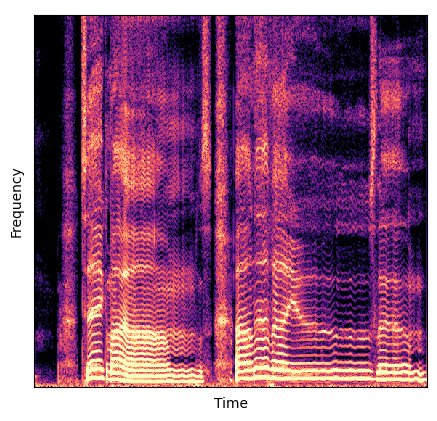

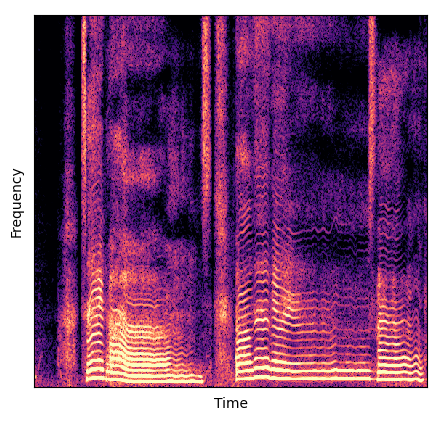

In [6]:
batch = audio_features
# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
util.specplot(audio)
util.play(audio)

print('Resynthesis')
util.specplot(audio_gen)
util.play(audio_gen)